In [1]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

**Загрузим данные**

In [2]:
# unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
# users = pd.read_table('data/ml-1m/users.dat', sep='::',
#                             header=None, names=unames)
# rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
# ratings = pd.read_table('data/ml-1m/ratings.dat', sep='::',
#                             header=None, names=rnames)
# mnames = ['movie_id', 'title', 'genres']
# movies = pd.read_table('data/ml-1m/movies.dat', sep='::',
#                             header=None, names=mnames)

In [3]:
movies = pd.read_csv('data/ml-latest-small/movies.csv')
movies.columns = ['movie_id', 'title', 'genres']

ratings = pd.read_csv('data/ml-latest-small/ratings.csv').drop('timestamp', axis = 1)
ratings.columns = ['user_id', 'movie_id', 'rating']

**1.Оценить количество фильмов, пользователей и оценок**

In [4]:
ratings['movie_id'].nunique(), ratings['user_id'].nunique(), ratings.shape[0]

(9724, 610, 100836)

**2.Оценить распределения (предлагается построить распределения количества оценок по <br>фильмам и пользователям и увидеть т.н. "длинные хвосты" в распределениях)**

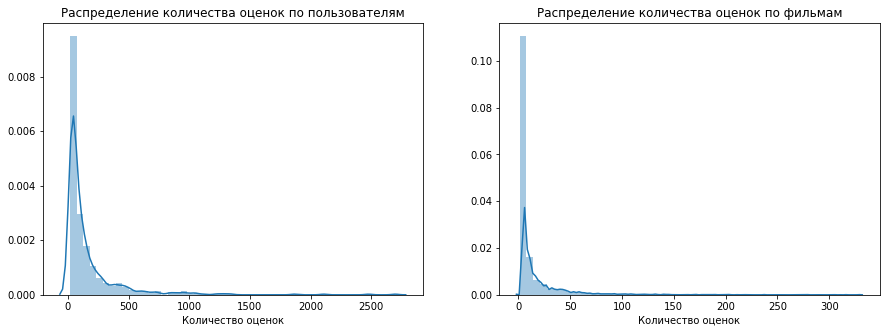

In [5]:
#Распределение количества оценок по пользователям
plt.figure(figsize = (15, 5))
users_review = ratings.groupby('user_id')['movie_id'].count().reset_index().\
                       rename(columns = {'movie_id':'cnt_reviews'})                     
plt.subplot(1, 2, 1)
sns.distplot(users_review['cnt_reviews'])
plt.title('Распределение количества оценок по пользователям') 
plt.xlabel('Количество оценок');

#Распределение количества оценок по фильмам
movie_review = ratings.groupby('movie_id')['user_id'].count().reset_index().\
                       rename(columns = {'user_id':'cnt_reviews'})

plt.subplot(1, 2, 2)
sns.distplot(movie_review['cnt_reviews'])
plt.title('Распределение количества оценок по фильмам') 
plt.xlabel('Количество оценок');

**3.Оценить средние оценки по фильмам и по пользователям**

In [6]:
#Средняя оценка фильму
ratings.groupby('movie_id')['rating'].mean().reset_index()['rating'].mean()

3.2624482748109656

In [7]:
#Средняя оценка пользователя
ratings.groupby('user_id')['rating'].mean().reset_index()['rating'].mean()

3.657222337747402

**4.Выбрать критерий, показывающий, что фильм нравится всем, <br>или не нравится никому, и вывести топ фильмов из этих списков. <br>Знаете ли вы эти фильмы, согласны ли с оценками?**

In [8]:
# Для каждого фильма выведем среднюю оценку и количество оценок
data = pd.merge(ratings, movies, how = 'left', on = 'movie_id')
m4 = data.groupby(['movie_id', 'title']).agg({'rating':'mean', 'user_id':'count'}).reset_index().\
                                    rename(columns = {'rating':'mean_rating', 'user_id':'cnt_users'})

#Чтобы оценка более робастной сделаем фильтр более 100 оценок
m4 = m4.query("""cnt_users > 100""")
m4.head()

,movie_id,title,mean_rating,cnt_users
0,1,Toy Story (1995),3.920930,215
1,2,Jumanji (1995),3.431818,110
5,6,Heat (1995),3.946078,102
9,10,GoldenEye (1995),3.496212,132
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


In [9]:
#топ 5 фильмов которые всем нравятся 
m4.sort_values('mean_rating', ascending = False).head(5)

,movie_id,title,mean_rating,cnt_users
277,318,"Shawshank Redemption, The (1994)",4.429022,317
659,858,"Godfather, The (1972)",4.289062,192
2224,2959,Fight Club (1999),4.272936,218
921,1221,"Godfather: Part II, The (1974)",4.259690,129
6298,48516,"Departed, The (2006)",4.252336,107


In [10]:
#топ 5 фильмов которые никому не нравятся 
m4.sort_values('mean_rating', ascending = True).head(5)

,movie_id,title,mean_rating,cnt_users
176,208,Waterworld (1995),2.913043,115
126,153,Batman Forever (1995),2.916058,137
504,586,Home Alone (1990),2.995690,116
378,434,Cliffhanger (1993),3.034653,101
156,185,"Net, The (1995)",3.040179,112


**5. Выбрать лучшие фильмы** <br>

<br>
Здесь можно воспользоваться подходом из 4 задания

In [11]:
m4.sort_values('mean_rating', ascending = False).head(5)['title'].values

array(['Shawshank Redemption, The (1994)', 'Godfather, The (1972)',
       'Fight Club (1999)', 'Godfather: Part II, The (1974)',
       'Departed, The (2006)'], dtype=object)

**6. Посмотреть на смещение оценок, увидеть сколько пользователей занижают оценки и завышают оценки.**

In [12]:
# В таблицу с рейтингами добавим средний рейтинг фильмов
ratings_with_mean = pd.merge(ratings, 
                             ratings.groupby('movie_id')['rating'].median(). \
                             reset_index().rename(columns = {'rating':'mean_movie_rating'}),
                             how = 'left', on = 'movie_id')
print(ratings.shape[0] == ratings_with_mean.shape[0])
ratings_with_mean.head()

True


,user_id,movie_id,rating,mean_movie_rating
0,1,1,4.0,4.0
1,1,3,4.0,3.0
2,1,6,4.0,4.0
3,1,47,5.0,4.0
4,1,50,5.0,4.5


In [13]:
#количество пользователей которые завышают оценки
ratings_with_mean[ratings_with_mean.rating > ratings_with_mean.mean_movie_rating]['user_id'].nunique()

605

In [14]:
#количество пользователей которые занижают оценки
ratings_with_mean[ratings_with_mean.rating < ratings_with_mean.mean_movie_rating]['user_id'].nunique()

606

**7. Построить рекомендательную систему с помощью библиотеки surprise (или другой, по желанию). <br>
Применить подбор параметров модели на сетке, оценить качество полученной модели по выбранной вами метрике.**

In [15]:
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import Reader, Dataset, evaluate

from surprise import NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [16]:
reader = Reader()
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

In [17]:
#Попробуем несколько алгоритмов
benchmark = []
# Iterate over all algorithms
# for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), 
#                   KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), 
#                   BaselineOnly(), CoClustering()]:
for algorithm in [SVD()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    #Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.879494,5.434004,0.466827


**8. Получить рекомендации для нового пользователя, совпадают ли они с лучшими фильмами?**

In [89]:
#Обучим модель
algo = SVD()
algo.fit(data.build_full_trainset())

In [90]:
def get_recommended_movies(model, user_id, movies = movies, ratings = ratings):
    """Для каждого фильма делаем предикт"""
    df = movies.copy()
    df['rating'] = df['movie_id'].apply(lambda x: model.predict(user_id, x)[3]).astype(float)
    
    #Удалим фильмы которые пользователь уже смотрел
    movies_already_seen = ratings[ratings.user_id == user_id]['movie_id']
    df = df.loc[~df['movie_id'].isin(movies_already_seen)]
    return df.sort_values('rating', ascending = False)

#холодный старт
top20_new_user = get_recommended_movies(model = algo, user_id = -999)
top20_new_user.head(20)

,movie_id,title,genres,rating
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.397608
906,1204,Lawrence of Arabia (1962),Adventure|Drama|War,4.343498
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.308775
841,1104,"Streetcar Named Desire, A (1951)",Drama,4.273485
914,1213,Goodfellas (1990),Crime|Drama,4.253516
680,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance,4.247950
899,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.247881
975,1276,Cool Hand Luke (1967),Drama,4.245403
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.232772
2582,3451,Guess Who's Coming to Dinner (1967),Drama,4.231303


In [91]:
# Лучшие топ 20 фильмов по среднему рейтингу
top20_movies_id = set(m4.sort_values('mean_rating', ascending = False).head(n = 20)['movie_id'])
m4.sort_values('mean_rating', ascending = False).head(n = 20)

,movie_id,title,mean_rating,cnt_users
277,318,"Shawshank Redemption, The (1994)",4.429022,317
659,858,"Godfather, The (1972)",4.289062,192
2224,2959,Fight Club (1999),4.272936,218
921,1221,"Godfather: Part II, The (1974)",4.259690,129
6298,48516,"Departed, The (2006)",4.252336,107
913,1213,Goodfellas (1990),4.250000,126
6693,58559,"Dark Knight, The (2008)",4.238255,149
46,50,"Usual Suspects, The (1995)",4.237745,204
898,1197,"Princess Bride, The (1987)",4.232394,142
224,260,Star Wars: Episode IV - A New Hope (1977),4.231076,251


In [92]:
# Посчитаем пересечение двух множеств
set(top20_new_user.head(20).movie_id.values).intersection(top20_movies_id)

{50, 318, 858, 1197, 1198, 1208, 1213, 1221, 2959, 48516}

**В итоге 10 фильмов пересекаются из топ 20 совпадают**

**9. Поставьте оценку какому-нибудь фильму (который вы знаете и можете поставить оценку) и получите рекомендации, насколько они качественные по вашим ощущениям? Сделайте это для фильма с негативной оценкой и для фильма с позитивной оценкой.**

In [96]:
def get_updated_ratings(reviews, ratings = ratings, user_id = -999, reader = reader):
    "Добавляем оценки для пользователя"
    df = ratings[['user_id', 'movie_id', 'rating']].copy()
    for movie_id, rating in reviews:
        df = pd.concat([df, 
                 pd.DataFrame([[user_id, movie_id, rating]], columns = ['user_id', 'movie_id', 'rating'])])
    
    return df

In [112]:
#Добавим положительную оценку для Interstellar (2014) id = 109487 и Armageddon (1998) id = 1917
#Добавим отрицательную оценку для драмы. Пусть будет Shawshank Redemption, The (1994) 318
reviews = [[109487,5], [1917,5], [924,3], [318, 1] ]
df = get_updated_ratings(reviews)

algo2 = SVD()
algo2.fit(Dataset.load_from_df(df[['user_id', 'movie_id', 'rating']], reader).build_full_trainset())

get_recommended_movies(model = algo2, user_id = -999, ratings = df).sort_values('rating', ascending = False).head(20)

,movie_id,title,genres,rating
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.405913
924,1223,"Grand Day Out with Wallace and Gromit, A (1989)",Adventure|Animation|Children|Comedy|Sci-Fi,4.395921
461,527,Schindler's List (1993),Drama|War,4.362536
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.350203
906,1204,Lawrence of Arabia (1962),Adventure|Drama|War,4.309489
6522,54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX,4.304531
5954,34405,Serenity (2005),Action|Adventure|Sci-Fi,4.304151
2789,3730,"Conversation, The (1974)",Drama|Mystery,4.295770
692,910,Some Like It Hot (1959),Comedy|Crime,4.287840
961,1262,"Great Escape, The (1963)",Action|Adventure|Drama|War,4.274393


**Набор фильмов изменился по сравнению с рекомендациями из холодного старта. <br>Оценить выборку для меня проблематично так как большую часть фильмов я не смотрел. <br>Но видно, что попали фильмы Sci - Fi**

---

**10. Добавляйте оценки и посмотрите, как изменяются рекомендации фильмов. Соответствуют ли они вашим предпочтениям? Есть ли недостатки у системы? Сколько нужно оценок для того, чтобы рекомендации стали релевантными? (в этом пункте добавляйте оценки в том числе из интересного вам жанра для пункта 11)**
**11. Построить рекомендательную систему по подвыборке - выбрать интересный вам жанр. Изменились ли рекомендации? Стали лучше\хуже?**

In [113]:
#Попробуем добавлять оценки для хоррор
"""
Dracula (1931)(2644)
Alien (1979) (1214)
Jaws (1975) 1387
Mist, The (2007) 56145
Annabelle: Creation (2017) (175199)
"""

reviews = [[2644,5], [1214,5], [1387,5], [56145,5], [175199,4]]
df = get_updated_ratings(reviews)

algo3 = SVD()
algo3.fit(Dataset.load_from_df(df[['user_id', 'movie_id', 'rating']], reader).build_full_trainset())

get_recommended_movies(model = algo3, user_id = -999, ratings = df).sort_values('rating', ascending = False).head(20)

,movie_id,title,genres,rating
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.805064
920,1219,Psycho (1960),Crime|Horror,4.796913
929,1228,Raging Bull (1980),Drama,4.780188
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.762807
4800,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,4.754555
1616,2160,Rosemary's Baby (1968),Drama|Horror|Thriller,4.753804
2094,2788,Monty Python's And Now for Something Completel...,Comedy,4.738478
7355,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,4.726254
2996,4011,Snatch (2000),Comedy|Crime|Thriller,4.725808
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.719638


**Здесь появились хорроры и триллеры. Думаю что рекомендации соответствуют просмотренным фильмам**